# Medical Data Science - Classification of Chest X-Rays
Fabian Friedrich, Konstantin Lobmayer, Amelia Witon

This dataset is a combination of COVID-19, Lung-Opacity, Normal, Viral Pneumonia and Tuberculosis classes.

| Class Name        | Number of samples | Labels |
|-------------------|-------------------|--------|
| COVID-19          | 4,189             | 0      |
| Lung-Opacity      | 6,012             | 1      |
| Normal            | 10,192            | 2      |
| Viral Pneumonia   | 7,397             | 3      |
| Tuberculosis      | 4,897             | 4      |
| Total             | 32,687            |        |

# Prep work

In [1]:
# Standard imports
import os
import csv
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import Flatten
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

# Captum
import torchvision
from captum.attr import Saliency, LayerGradCam
from captum.attr import visualization as viz


/home/fabi/code/university/medical-data-science/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
figures_dir = 'figures/'
os.makedirs(figures_dir, exist_ok=True)

In [3]:
label_mapping = {
    0: 'COVID-19',
    1: 'Lung-Opacity',
    2: 'Normal',
    3: 'Viral Pneumonia',
    4: 'Tuberculosis'
}

### Convert npz to png files

In [16]:
def preprocess_and_save_images(file_path, output_dir):
    data = np.load(file_path)

    os.makedirs(output_dir, exist_ok=True)

    startIndex = 19380
    for i, (image, label) in enumerate(zip(data['image'][startIndex:], data['image_label'][startIndex:])):
        label_dir = os.path.join(output_dir, str(label[0]))
        os.makedirs(label_dir, exist_ok=True)

        filename = os.path.join(label_dir, f"{i + startIndex}.png")

        plt.imshow(image / 255.0)
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)  

        plt.close()  

<div style="color:red">WARNING: This loads the whole numpy array in to your memory! train.npz needs at least 32GB of RAM!</div>

Download images from here and skip this step: [https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing](https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing)  

Or download the npz files and convert to png yourself: [https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI) 

In [4]:
preprocess_and_save_images("train.npz", "images/train")

In [3]:
preprocess_and_save_images("test.npz", "images/test")

In [ ]:
preprocess_and_save_images("val.npz", "images/val")

### CLAHE

In [4]:
clahe_dir = 'clahe/'
os.makedirs(clahe_dir, exist_ok=True)
clahe_train_dir = f"{clahe_dir}/train"
clahe_test_dir = f"{clahe_dir}/test"
clahe_val_dir = f"{clahe_dir}/val"
os.makedirs(clahe_train_dir, exist_ok=True)
os.makedirs(clahe_test_dir, exist_ok=True)
os.makedirs(clahe_val_dir, exist_ok=True)

In [5]:
def apply_clahe(image, brightness, clahe_limit):
    clahe = cv2.createCLAHE(clipLimit=clahe_limit)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe_img = clahe.apply(image_bw)
    clahe_img = np.clip(clahe_img, 0, (255-brightness))
    final_img = clahe_img + brightness
    return final_img

def save_image(image, label, path, img_name):
    label_dir = os.path.join(path, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    cv2.imwrite(os.path.join(label_dir, f'{img_name}'), image)

In [5]:
def create_clahe(dir, clahe_dir):
    for label in os.listdir(dir):
        for img_name in os.listdir(os.path.join(dir, label)):
            img_path = os.path.join(dir, label, img_name)
            image = cv2.imread(img_path) 
            clahe_image = apply_clahe(image,5,5)
            save_image(clahe_image, label, clahe_dir, img_name)


In [11]:
create_clahe("images/train", clahe_train_dir)

In [ ]:
create_clahe("images/test", clahe_test_dir)

In [ ]:
create_clahe("images/val", clahe_val_dir)

Difference between CLAHE and Original with Pixel Distribution Chart

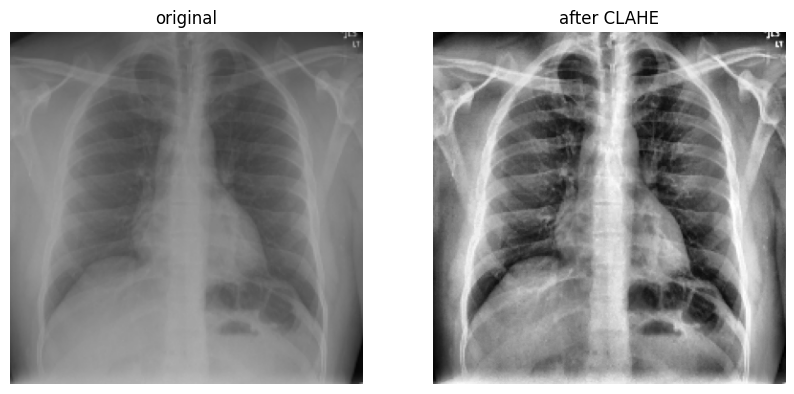

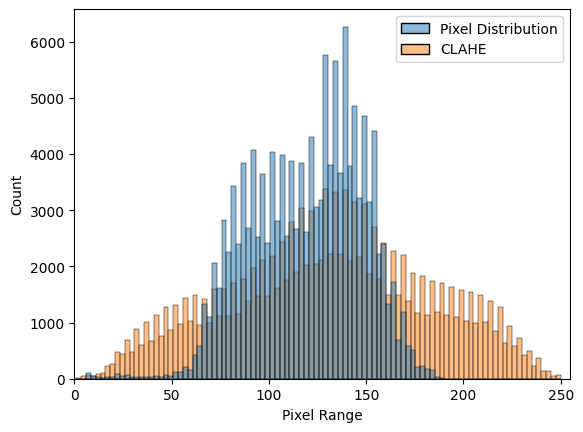

In [6]:
images_train_dir = 'images/train'

random_label = random.choice(os.listdir(images_train_dir))
random_img_name = random.choice(os.listdir(os.path.join(images_train_dir, random_label)))
random_img_path = os.path.join(images_train_dir, random_label, random_img_name)
random_image = cv2.imread(random_img_path)

clahe_random_image = apply_clahe(random_image, 0, 5)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clahe_random_image, cmap='gray')
plt.title("after CLAHE")
plt.axis('off')
plt.savefig(f"{figures_dir}/Clahe_Comparison.png")

plt.show()

grayimg = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'CLAHE':np.array(clahe_random_image.flat)}
ax2 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax2.set(xlabel='Pixel Range',ylabel='Count');
plt.savefig(f"{figures_dir}/Pixel_Distribution.png")

### Define the Dataloder for the dataset

In [4]:
class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.img_paths = self._get_img_paths()

    def _get_img_paths(self):
        img_paths = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                img_paths.append((img_path, int(cls_name)))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.GRAY)
        image = image.float() / 255.0

        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
normalize_transform = transforms.Normalize(mean=[0.5], std=[0.5]) 
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),      
    normalize_transform  
])

In [6]:
use_clahe = True

root_dir = 'clahe' if use_clahe else 'images'

train_dir = f"{root_dir}/train"
test_dir = f"{root_dir}/test"
val_dir = f"{root_dir}/val"

In [7]:
train_dataset = XRayDataset(train_dir, transform=data_transform)
test_dataset = XRayDataset(test_dir, transform=normalize_transform)
val_dataset = XRayDataset(val_dir, transform=normalize_transform)

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Data Point Diagramm

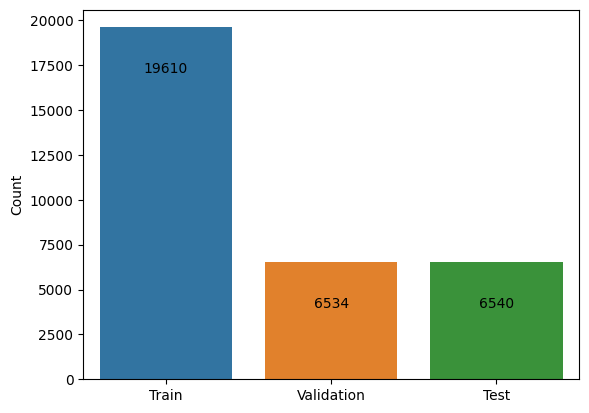

In [13]:
num_train = len(train_dataset)
num_test = len(test_dataset)
num_val = len(val_dataset)

columns = ['Train', 'Validation', 'Test']
ax3 = sns.barplot(x=columns, y=[num_train, num_val, num_test], hue=columns)

ax3.set_ylabel('Count')

for p, label in zip(ax3.patches, [num_train, num_val, num_test]):
    ax3.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, -30), textcoords='offset points')
plt.savefig(f"{figures_dir}/Split_Comparison.png")
plt.show()


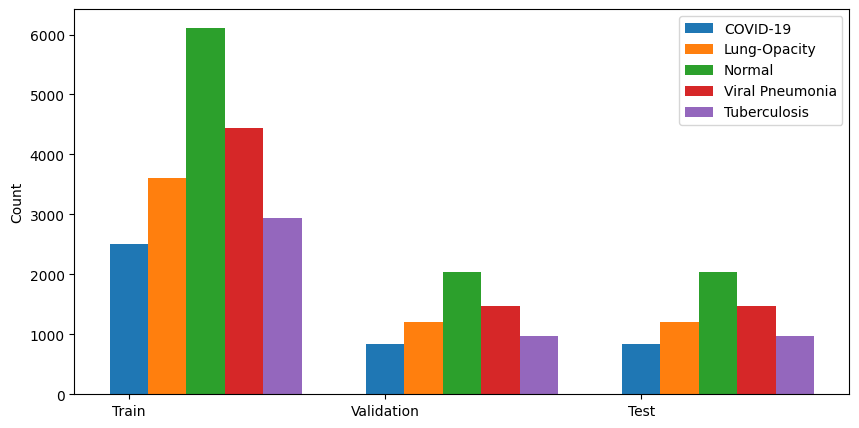

In [246]:
def get_class_counts(dataset):
    class_counts = {label: 0 for label in range(5)}
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

train_class_counts = get_class_counts(train_dataset)
test_class_counts = get_class_counts(test_dataset)
val_class_counts = get_class_counts(val_dataset)

class_names = [label_mapping[label] for label in range(5)]
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.15
bar_positions = np.arange(3)

for i in range(5):
    ax.bar(bar_positions + i * bar_width, [train_class_counts[i], val_class_counts[i], test_class_counts[i]], bar_width, label=class_names[i])

ax.set_xticks(bar_positions)
ax.set_xticklabels(['Train', 'Validation', 'Test'])
ax.legend()
ax.set_ylabel('Count')
plt.savefig(f"{figures_dir}/Class_Comparison.png")
plt.show()

### Show one example image

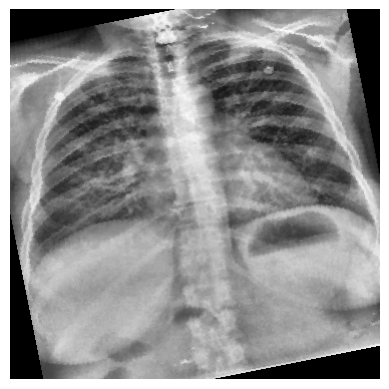

Label: tensor(4)


In [16]:
images, labels = next(iter(train_loader))

image = images[0].permute(1, 2, 0).numpy()  
plt.imshow(image, cmap='gray')
plt.axis('off')
fig_path = f"{figures_dir}/Example_Image.png" if not use_clahe else f"{figures_dir}/Example_Image_Clahe.png"
plt.savefig(fig_path)
plt.show()

print("Label:", labels[0])


## Define Neural Network

#### (skip this step) Setting the environment variables for amd rx6700xt  

In [9]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env HCC_AMDGPU_TARGET=gfx1032

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: HCC_AMDGPU_TARGET=gfx1032


#### Creating Device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
num_classes = 5

#### Using pretrained model

In [12]:
using_resnet50 = True

if not using_resnet50:
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # adjust output layer to have num_classes outputs
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
else:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # adjust output layer to have num_classes outputs
    model.fc = nn.Sequential(
        Flatten(),
        nn.Linear(2048, 1028),
        nn.Linear(1028, 512),
        nn.Linear(512, num_classes)
    )
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define Loss Function and Optimizer Function

In [13]:
variant="resnet18_rgb_data_augmentation_clahe"

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
num_epochs = 12
starting_epoch=0 # what previous epoch to use for training, standard is 0


save_dir = "saved_models"
if starting_epoch!=0:
    model.load_state_dict(torch.load(f'{save_dir}/{variant}_epoch_{starting_epoch}.pth'))
    
os.makedirs(save_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/{variant}", exist_ok=True)

print(f"Training {variant} for {num_epochs} epochs")
with open(f"{figures_dir}/{variant}/train_accuracy.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"])
    for epoch in range(num_epochs):

        train_total = 0
        train_correct = 0
        val_correct = 0
        val_total = 0
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        with tqdm(train_loader, desc=f'Epoch {epoch+1+starting_epoch}/{num_epochs+starting_epoch}', leave=False) as t:
            for i, data in enumerate(t):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                rgb_inputs = torch.cat([inputs, inputs, inputs], dim=1)
                rgb_inputs = rgb_inputs.to(device)
                outputs = model(rgb_inputs)

                _, predicted = torch.max(outputs.data, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                
                t.set_postfix(loss=train_loss / (i + 1))

        model.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                rgb_inputs = torch.cat([inputs, inputs, inputs], dim=1)
                rgb_inputs = rgb_inputs.to(device)
                outputs = model(rgb_inputs)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        writer.writerow([epoch, train_correct / train_total, val_correct / val_total, train_loss / len(train_loader), val_loss / len(val_loader)])

        # Save the model at the end of each epoch
        epoch_save_path = os.path.join(save_dir, f"{variant}_epoch_{epoch+1+starting_epoch}.pth")
        torch.save(model.state_dict(), epoch_save_path)

        print(f"""Epoch {epoch + 1 + starting_epoch}/{num_epochs + starting_epoch}, 
                  Train Loss: {train_loss / len(train_loader)}, 
                  Val Loss: {val_loss / len(val_loader)},
                  Train Accuracy: {train_correct / train_total},
                  Validation Accuracy: {val_correct / val_total}""")

Training resnet18_rgb_data_augmentation_clahe for 12 epochs


Epoch 1/12, 
                  Train Loss: 0.35149040923349034, 
                  Val Loss: 0.7183849967107541,
                  Train Accuracy: 0.876134625191229,
                  Validation Accuracy: 0.7548209366391184


Epoch 2/12, 
                  Train Loss: 0.1982897313290426, 
                  Val Loss: 0.16874666882724296,
                  Train Accuracy: 0.9298827129015809,
                  Validation Accuracy: 0.9418426691153964


Epoch 3/12, 
                  Train Loss: 0.15786424413517872, 
                  Val Loss: 0.16607696178664522,
                  Train Accuracy: 0.9426823049464559,
                  Validation Accuracy: 0.9413835322926232


Epoch 4/12, 
                  Train Loss: 0.1377566138625777, 
                  Val Loss: 0.16925567217262052,
                  Train Accuracy: 0.9525752167261601,
                  Validation Accuracy: 0.9432200795837159


Epoch 5/12, 
                  Train Loss: 0.12090787752630222, 
                  Val Loss: 0.16043033604850856,
                  Train Accuracy: 0.9560428352881183,
                  Validation Accuracy: 0.9449035812672176


Epoch 6/12, 
                  Train Loss: 0.11524397167369578, 
                  Val Loss: 0.1513781850044502,
                  Train Accuracy: 0.9586435492095869,
                  Validation Accuracy: 0.9520967248239975


Epoch 7/12, 
                  Train Loss: 0.10113532282260124, 
                  Val Loss: 0.13242850806336942,
                  Train Accuracy: 0.9654258031616522,
                  Validation Accuracy: 0.9565350474441383


Epoch 8/12, 
                  Train Loss: 0.09642603406743382, 
                  Val Loss: 0.1339280191138841,
                  Train Accuracy: 0.9670576236613972,
                  Validation Accuracy: 0.9550045913682277


Epoch 9/12, 
                  Train Loss: 0.08587137539947001, 
                  Val Loss: 0.15739477796184762,
                  Train Accuracy: 0.971443141254462,
                  Validation Accuracy: 0.9522497704315886


Epoch 10/12, 
                  Train Loss: 0.07522866303111816, 
                  Val Loss: 0.16823614685364613,
                  Train Accuracy: 0.9733809280979092,
                  Validation Accuracy: 0.9445974900520355


Epoch 11/12, 
                  Train Loss: 0.08043897591818422, 
                  Val Loss: 0.13402693966267312,
                  Train Accuracy: 0.9710861805201428,
                  Validation Accuracy: 0.9573002754820936


Epoch 12/12, 
                  Train Loss: 0.07154046172590632, 
                  Val Loss: 0.22031271059702082,
                  Train Accuracy: 0.9737888832228455,
                  Validation Accuracy: 0.926232017141108


#### Plot loss over epochs

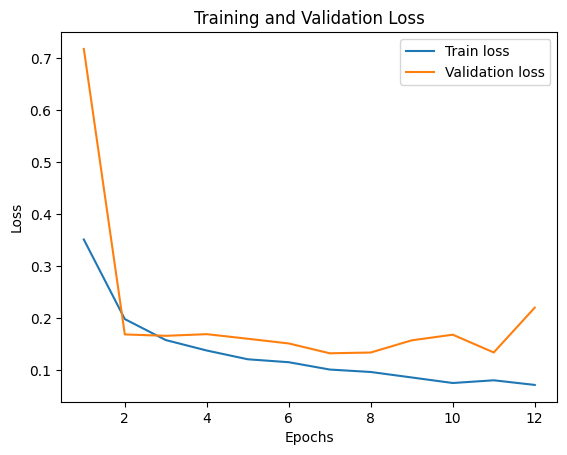

In [17]:
train_loss_list = []
val_loss_list = []

with open(f"{figures_dir}/{variant}/train_accuracy.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        train_loss_list.append(float(row['Train Loss']))
        val_loss_list.append(float(row['Validation Loss']))

epochs = range(1, len(train_loss_list) + 1)

plt.plot(epochs, train_loss_list, label='Train loss')  
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
os.makedirs(f"{figures_dir}/{variant}", exist_ok=True)
plt.savefig(f"{figures_dir}/{variant}/loss_plot.png")
plt.show()


#### Plot accuracy over epochs

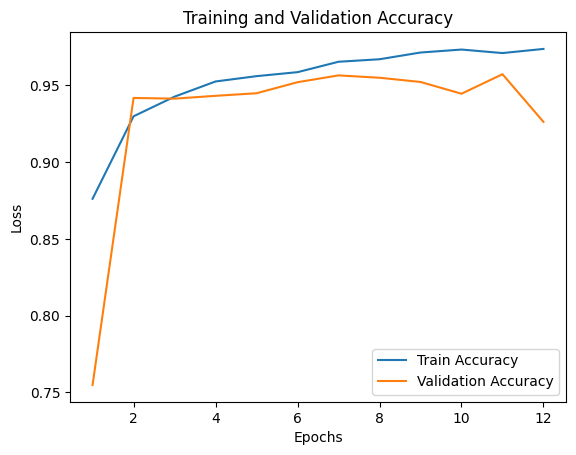

In [18]:
train_accuracy_list = []
val_accuracy_list = []
with open(f"{figures_dir}/{variant}/train_accuracy.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        train_accuracy_list.append(float(row['Train Accuracy']))
        val_accuracy_list.append(float(row['Validation Accuracy']))

epochs = range(1, len(train_accuracy_list) + 1)

plt.plot(epochs, train_accuracy_list, label='Train Accuracy')  
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
os.makedirs(f"{figures_dir}/{variant}", exist_ok=True)
plt.savefig(f"{figures_dir}/{variant}/accuracy_plot.png")
plt.show()

### Calculate Accuracy

In [46]:
epoch=11
model.load_state_dict(torch.load(f'saved_models/{variant}_epoch_{epoch}.pth'))
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
predicted_labels = []
true_labels = []
attention_masks = []

with open(f'figures/{variant}/predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["True Label", "Predicted Label", "f1-score", "image path"])
    with torch.no_grad(), tqdm(total=len(test_loader.dataset)) as pbar:
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            rgb_inputs = torch.cat([images, images, images], dim=1)
            rgb_inputs = rgb_inputs.to(device)
            outputs = model(rgb_inputs) 
            
            _, predicted = torch.max(outputs, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            f1 = f1_score(labels.cpu().data, predicted.cpu(), average='weighted')
            for j in range(len(labels)):
                label = label_mapping[labels.cpu().numpy()[j]]
                pred = label_mapping[predicted.cpu().numpy()[j]]
                writer.writerow([label, pred, f1, test_loader.dataset.img_paths[i*batch_size + j][0]])
            
            # attention_masks.extend(attention.cpu().numpy())
            pbar.update(len(labels))            

            # Log predictions
            #log_predictions(image path, labels(the correct answer), predicted, attention)

accuracy = 100 * correct / total
print('Accuracy of the network on the test images: %.2f %%' % accuracy)

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
attention_masks = np.array(attention_masks)

  0%|          | 0/6540 [00:00<?, ?it/s]

100%|██████████| 6540/6540 [00:19<00:00, 332.40it/s]

Accuracy of the network on the test images: 95.50 %


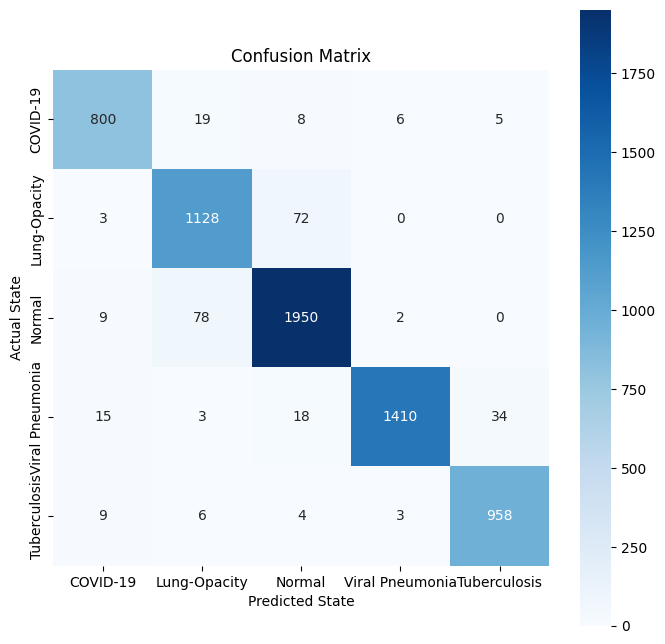

In [47]:
images, class_labels = next(iter(train_loader))
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_sliced = conf_matrix[:5, :5]
class_labels_mapped = [label_mapping[label.item()] for label in class_labels.unique()]

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_sliced, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels_mapped, yticklabels=class_labels_mapped)
plt.xlabel('Predicted State')
plt.ylabel('Actual State')
plt.title('Confusion Matrix')
os.makedirs(f"{figures_dir}/{variant}", exist_ok=True)
plt.savefig(f"{figures_dir}/{variant}/epoch_{epoch}_confusion_matrix.png")
plt.show()


# AI Explainability

In [48]:
torch.manual_seed(123)
np.random.seed(123)

In [49]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

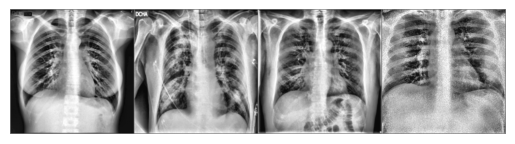

GroundTruth:  tensor(0) tensor(0) tensor(0) tensor(0)
Predicted:  tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0')


In [54]:
xai_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

dataiter = iter(xai_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

images, labels = images.to(device), labels.to(device)
rgb_inputs = torch.cat([images, images, images], dim=1)
rgb_inputs = rgb_inputs.to(device)
outputs = model(rgb_inputs)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

In [55]:
ind = 2

input = images[ind].unsqueeze(0)
input.requires_grad = True
input = torch.cat([input, input, input], dim=1)
input = input.to(device)

#### Saliency

In [56]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())
grads = grads[0].cpu().numpy().transpose(1, 2, 0)
print(grads.shape)

(369, 369, 3)


#### Layer Grad Cam

In [57]:
layerGradCam = LayerGradCam(model, model.layer4)
attr_gc = layerGradCam.attribute(input, target=labels[ind])

# Upsampling the attribute map to the size of the input image
upsampled_attr_gc = F.interpolate(attr_gc, size=input.size()[2:], mode='bilinear', align_corners=False)
upsampled_attr_gc = upsampled_attr_gc[0].cpu().detach().numpy().transpose(1, 2, 0)
print(upsampled_attr_gc.shape)

(369, 369, 1)


### Drawing all the maps

Predicted: COVID-19
Ground Truth: COVID-19


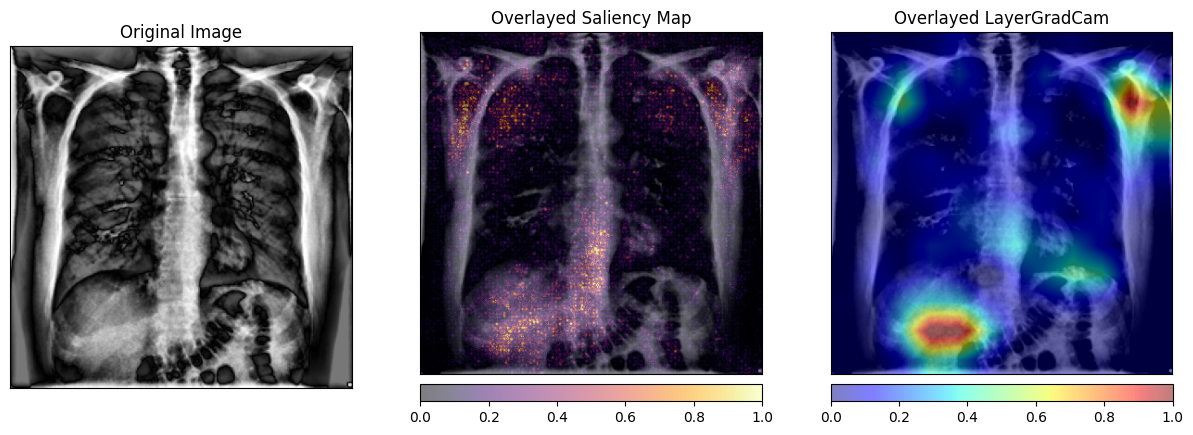

In [58]:
predicted_label = label_mapping[predicted[ind].item()]
print("Predicted:", predicted_label)
print("Ground Truth:", label_mapping[labels[ind].item()])

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

original_image = images[ind].cpu().numpy().transpose(1, 2, 0)
_ = viz.visualize_image_attr(original_image, original_image, method="blended_heat_map", 
                             title="Original Image", cmap="gray", plt_fig_axis=(fig, axes[0]), use_pyplot=False)

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, 
                             title="Overlayed Saliency Map", plt_fig_axis=(fig, axes[1]), use_pyplot=False, cmap="inferno")

_ = viz.visualize_image_attr(upsampled_attr_gc, original_image, method="blended_heat_map", sign="positive", show_colorbar=True,
                             title="Overlayed LayerGradCam", plt_fig_axis=(fig, axes[2]), use_pyplot=False, cmap="jet")

os.makedirs(f"{figures_dir}/{variant}", exist_ok=True)
fig.savefig(f"{figures_dir}/{variant}/xai.png", bbox_inches='tight', pad_inches=0)

Saving figs separately as pngs

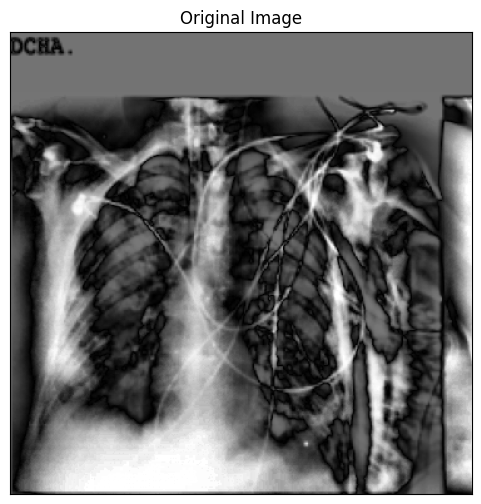

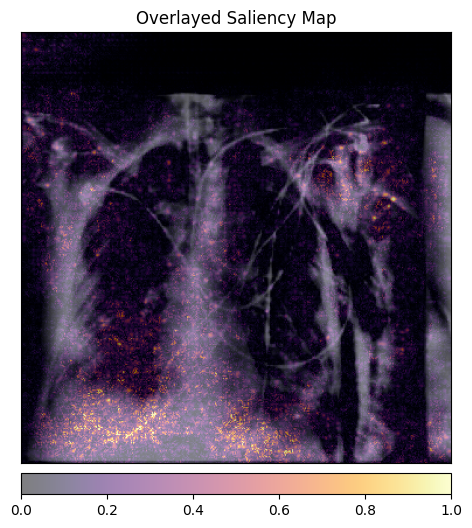

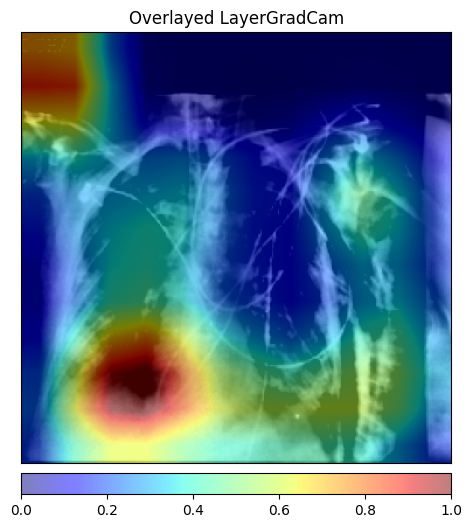

In [57]:
original = viz.visualize_image_attr(original_image, original_image, method="blended_heat_map", 
                             title="Original Image", cmap="gray")
original[0].savefig(f"{figures_dir}/{variant}/{label_mapping[labels[ind].item()]}_original.png")

saliency = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, 
                             title="Overlayed Saliency Map", cmap="inferno")
saliency[0].savefig(f"{figures_dir}/{variant}/{label_mapping[labels[ind].item()]}_saliency.png")

grad_cam = viz.visualize_image_attr(upsampled_attr_gc, original_image, method="blended_heat_map", sign="positive", show_colorbar=True,
                             title="Overlayed LayerGradCam", cmap="jet")
grad_cam[0].savefig(f"{figures_dir}/{variant}/{label_mapping[labels[ind].item()]}_grad_cam.png")